In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt
from fuzzy_layer import FuzzyLayer
import matplotlib.pyplot as plt


np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
timeseries_length = 80

Сгенерируем синтетический набор данных в виде треугольной функции с двумя параметрами - положением центра по оси x и ширина основания.
Для простоты будем полaгать что ширина основания треугольника лежит в диапазоне от 1 до 2, а центр может располагаться в диапазоне от 1 до 9.

Присвоим следующие метки для случаев: 

1. Треугольник в начале отрезка и шириной 1
2. Треугольник в начале отрезка и шириной 2
3. Треугольник в конце отрезка и шириной 1
4. Треугольник в конце отрезка и шириной 2
5. Любые другие комбинации положений и ширин

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, samples_count, timeseries_length):
        'Initialization'
        self.samples = samples_count
        self.timeseries_length = timeseries_length
    
    def __len__(self):
        'Denotes the total number of samples'
        return self.samples
    
    def triangle(self, x, center, d):
        if x <= center - d or x >= center + d:
            return 0
        elif x <= center:
            return (x - center + d)/d
        else:
            return (center + d - x)/d
    
    def __getitem__(self, index):
        'Generates one sample of data'
        
        center = 1 + 8*np.random.random()
        width = 0.5 + np.random.random() / 2

        t = np.linspace(0.0, 10, self.timeseries_length)
        X = np.array([self.triangle(a, center, width) for a in t])

        X = torch.from_numpy(X.reshape((1,self.timeseries_length))).type('torch.FloatTensor')
        
        #todo: labeling
        y = 4
        
        return X, y
    
training_set = Dataset(1000, timeseries_length)
train_gen = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle = True, num_workers = 0, drop_last=True)

testing_set = Dataset(128, timeseries_length)
test_gen = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle = True, num_workers = 0, drop_last=True)

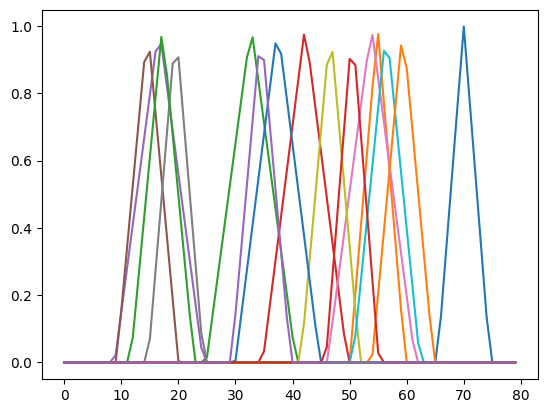

In [9]:
for X, y in test_gen:
  plt.plot(X[0,0])
  
plt.show()
    

Определим структуру VAE для одномерного сигнала

In [10]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.latent_dimension = 2

        self.common = nn.Sequential(
            nn.Conv1d(1, 32, 20),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, 20),
            nn.BatchNorm1d(64),
            nn.Flatten(),
            nn.Linear(2688, 1152),
            nn.BatchNorm1d(1152),
            nn.Sigmoid()
        )

        self.mu = nn.Sequential(
            nn.Linear(1152, self.latent_dimension),
            nn.BatchNorm1d(self.latent_dimension),
            nn.Sigmoid()
        )

        self.logvar = nn.Sequential(
            nn.Linear(1152, self.latent_dimension),
            nn.BatchNorm1d(self.latent_dimension),
            nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dimension, 1152),
            nn.BatchNorm1d(1152),
            nn.Sigmoid(),
            nn.Linear(1152, 2688),
            nn.BatchNorm1d(2688),
            nn.Sigmoid(),
            nn.Unflatten(1, [64, 42]),
            nn.ConvTranspose1d(64, 32, 20),
            nn.BatchNorm1d(32),
            nn.ConvTranspose1d(32, 1, 20)
        )


    def encode(self, x):
        conv = self.common.forward(x)
        mu = self.mu.forward(conv)
        logvar = self.logvar.forward(conv)
        return (mu, logvar)
    
    def decode(self, z_mean):
        return self.decoder.forward(z_mean)
        
    def forward(self, x):
        mu,_ = self.encode(x)
        return self.decoder(mu)
        
model = VAE().to(device)
input = torch.randn(10, 1, timeseries_length).to(device)


output = model(input)

output.shape

torch.Size([10, 1, 80])

Обучим модельку

In [17]:
lrate = 0.01
optimizer = torch.optim.Adam(
            model.parameters(),
            lr = lrate)

def VAE_loss(x_tilde, x, mu, logvar):
    mse = nn.functional.mse_loss(x_tilde, x, reduction = 'sum')
    KL = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return mse #+ KL 

In [18]:
def train_model(epochs, model):
    dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())
    for epoch in range(0, epochs + 1):
        # ========= training =========
        if epoch > 0: 
            model.train()
            train_loss = 0
            for X, _ in train_gen:
                X = X.to(device)
                # forward pass ...
                mu, logvar = model.encode(X)

                epsilon = torch.randn_like(mu).to(device)
                z = mu + torch.exp(0.5 * logvar) * epsilon      
                x_tilde = model.decode(z)


                loss = VAE_loss(x_tilde, X, mu, logvar)
                train_loss += loss.item()
                # backward pass ...
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # log ...
            print(f'----> Epoch: {epoch} Average loss: {train_loss / len(train_gen.dataset):.4f}')

        # ========= validation ========= 
        z_list, means, logvars , labels = list(), list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for X, Y in test_gen:
                X = X.to(device)
                # forward ...
                mu, logvar = model.encode(X)
                x_tilde = model.decode(mu)
                
                test_loss += VAE_loss(x_tilde, X, mu, logvar).item()
                # log ...
                z_list.append(mu.detach())
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(Y.detach())
        # log ...
        dic['latent_space'].append(torch.cat(z_list))
        dic['mu_list'].append(torch.cat(means))
        dic['logsig2_list'].append(torch.cat(logvars))
        dic['y'].append(torch.cat(labels))
        test_loss /= len(test_gen.dataset)
        print(f'----> Test set loss: {test_loss:.4f}')
    return dic
    
epochs = 50
dic = train_model(epochs, model)

----> Test set loss: 3.3350
----> Epoch: 1 Average loss: 197.3719
----> Test set loss: 26.5124
----> Epoch: 2 Average loss: 58.9704
----> Test set loss: 53.5797
----> Epoch: 3 Average loss: 30.1009
----> Test set loss: 24.0781
----> Epoch: 4 Average loss: 16.7116
----> Test set loss: 11.3738
----> Epoch: 5 Average loss: 9.1544
----> Test set loss: 6.4654
----> Epoch: 6 Average loss: 6.1665
----> Test set loss: 4.8754
----> Epoch: 7 Average loss: 4.5350
----> Test set loss: 4.2447
----> Epoch: 8 Average loss: 3.8076
----> Test set loss: 4.0313
----> Epoch: 9 Average loss: 3.5138
----> Test set loss: 3.5956
----> Epoch: 10 Average loss: 3.2857
----> Test set loss: 3.4321
----> Epoch: 11 Average loss: 3.1725
----> Test set loss: 3.3135
----> Epoch: 12 Average loss: 3.1603
----> Test set loss: 3.3144
----> Epoch: 13 Average loss: 3.1455
----> Test set loss: 3.3088
----> Epoch: 14 Average loss: 3.0953
----> Test set loss: 3.3044
----> Epoch: 15 Average loss: 3.1653
----> Test set loss: 3.34

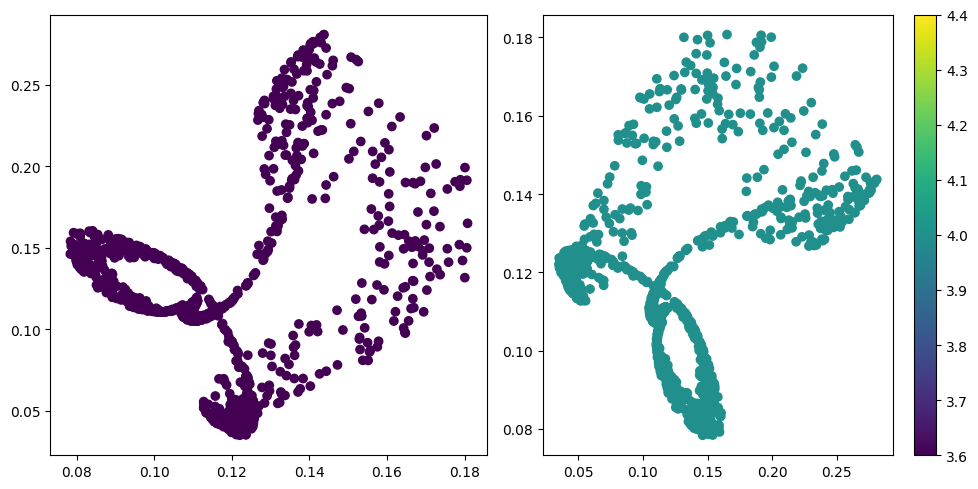

In [19]:
z_arr = dic['latent_space'][0].cpu().numpy()
y_arr = dic['y'][0].cpu().numpy()
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr)
plt.subplot(1,2,2)
plt.scatter(z_arr[:,1], z_arr[:,0], c = y_arr)
plt.colorbar()
plt.tight_layout()



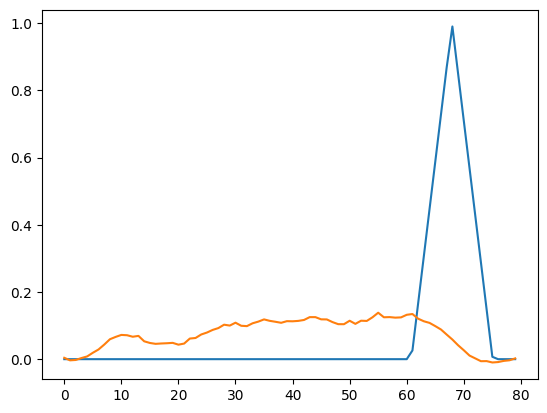

In [20]:
model.eval()
for X, y in test_gen:
    mu, logvar = model.encode(X)
    x_tilde = model.decode(mu)
    plt.plot(X[0,0])
    plt.plot(x_tilde.detach().numpy()[0,0])
    plt.show()
    break

In [ ]:
a = torch.randn(10, 1, timeseries_length, device=device)
b = torch.randn(10, 1, timeseries_length, device=device)

recon_loss = torch.square(a - b)
srecon_loss = recon_loss.sum(-1).sum(-1)
srecon_loss.sum()

tensor(1571.0114)